# Fine-tuning SBERT with Content-Based Pairs

This notebook fine-tunes SBERT using **content-based training pairs** that focus on job description content rather than titles.

## Approach
- **Loss Function**: Contrastive Loss
- **Base Model**: all-MiniLM-L6-v2
- **Training Data**: Content-based job-to-job pairs (from 1b_create_content_based_pairs.ipynb)
- **Focus**: Skills, duties, and requirements over job titles

In [1]:
# Fix for TensorFlow compatibility issues
import os
os.environ['USE_TF'] = '0'
os.environ['USE_TORCH'] = '1'

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 1. Load Content-Based Training Data

In [2]:
# Load the content-based job-to-job pairs
train_df = pd.read_csv('train_pairs_content_based.csv')
val_df = pd.read_csv('val_pairs_content_based.csv')
test_df = pd.read_csv('test_pairs_content_based.csv')

print(f"Train set: {len(train_df)} pairs")
print(f"Validation set: {len(val_df)} pairs")
print(f"Test set: {len(test_df)} pairs")

print(f"\nClass distribution (train):")
print(train_df['label'].value_counts())

print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nSample row:")
print(train_df.iloc[0][['job1_title', 'job2_title', 'label', 'skill_overlap', 'content_similarity']])

Train set: 4200 pairs
Validation set: 900 pairs
Test set: 900 pairs

Class distribution (train):
label
1    2100
0    2100
Name: count, dtype: int64

Columns: ['job1_idx', 'job2_idx', 'skill_overlap', 'category_overlap', 'content_similarity', 'semantic_similarity', 'same_title', 'label', 'job1_title', 'job2_title', 'job1_text', 'job2_text']

Sample row:
job1_title            Platform deployment runtime refactorization - ...
job2_title            Software Engineer in Test - MATLAB App Buildin...
label                                                                 1
skill_overlap                                                  0.333333
content_similarity                                             0.444491
Name: 0, dtype: object


## 2. Analyze Training Data Quality

In [3]:
# Check how many positive pairs have different titles
pos_df = train_df[train_df['label'] == 1]
neg_df = train_df[train_df['label'] == 0]

print("=" * 80)
print("TRAINING DATA QUALITY CHECK")
print("=" * 80)

print(f"\nPositive Pairs:")
print(f"  Total: {len(pos_df)}")
print(f"  Different titles: {(pos_df['same_title']==0).sum()} ({(pos_df['same_title']==0).sum()/len(pos_df)*100:.1f}%)")
print(f"  Avg skill overlap: {pos_df['skill_overlap'].mean():.3f}")
print(f"  Avg content similarity: {pos_df['content_similarity'].mean():.3f}")

print(f"\nNegative Pairs:")
print(f"  Total: {len(neg_df)}")
print(f"  Avg skill overlap: {neg_df['skill_overlap'].mean():.3f}")
print(f"  Avg content similarity: {neg_df['content_similarity'].mean():.3f}")

print(f"\n✓ This data focuses on CONTENT rather than job titles!")

TRAINING DATA QUALITY CHECK

Positive Pairs:
  Total: 2100
  Different titles: 1999 (95.2%)
  Avg skill overlap: 0.528
  Avg content similarity: 0.550

Negative Pairs:
  Total: 2100
  Avg skill overlap: 0.125
  Avg content similarity: 0.352

✓ This data focuses on CONTENT rather than job titles!


## 3. Prepare Data for Sentence-Transformers

In [4]:
def create_input_examples(df):
    """
    Convert DataFrame to InputExample format for sentence-transformers
    
    For contrastive loss:
    - label=1.0 means similar (positive pair)
    - label=0.0 means dissimilar (negative pair)
    """
    examples = []
    for idx, row in df.iterrows():
        example = InputExample(
            texts=[row['job1_text'], row['job2_text']],
            label=float(row['label'])
        )
        examples.append(example)
    return examples

print("Creating training examples...")
train_examples = create_input_examples(train_df)
print(f"Created {len(train_examples)} training examples")

print("\nSample training example:")
print(f"Job 1: {train_examples[0].texts[0][:150]}...")
print(f"Job 2: {train_examples[0].texts[1][:150]}...")
print(f"Label: {train_examples[0].label}")

Creating training examples...
Created 4200 training examples

Sample training example:
Job 1: Job Title: Platform deployment runtime refactorization - Summer Intern. Description: Job SummaryDo you want to gain experience using C++ in a producti...
Job 2: Job Title: Software Engineer in Test - MATLAB App Building Tool. Description: Job SummaryThe App Building team is seeking a highly motivated Software ...
Label: 1.0


## 4. Load Pre-trained Model

In [5]:
# Load the base model
model_name = 'all-MiniLM-L6-v2'
print(f"Loading base model: {model_name}...")
model = SentenceTransformer(model_name)

print(f"\nModel architecture:")
print(model)

print(f"\nEmbedding dimension: {model.get_sentence_embedding_dimension()}")

Loading base model: all-MiniLM-L6-v2...

Model architecture:
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Embedding dimension: 384


## 5. Set Up Data Loader

In [6]:
# Training parameters
BATCH_SIZE = 16  # Adjust based on GPU memory
NUM_EPOCHS = 4
WARMUP_STEPS = 100
EVALUATION_STEPS = 500

# Create data loader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Total training steps: {len(train_dataloader) * NUM_EPOCHS}")

Number of training batches: 263
Total training steps: 1052


## 6. Define Loss Function

In [7]:
# Contrastive Loss
# This loss function pulls similar pairs (label=1) together and pushes dissimilar pairs (label=0) apart
train_loss = losses.ContrastiveLoss(model=model)

print("Using Contrastive Loss:")
print("  - Positive pairs (label=1): Minimize distance between jobs with similar CONTENT")
print("  - Negative pairs (label=0): Maximize distance between jobs with different CONTENT")
print("  - Focus: Skills, duties, requirements (not just titles)")

Using Contrastive Loss:
  - Positive pairs (label=1): Minimize distance between jobs with similar CONTENT
  - Negative pairs (label=0): Maximize distance between jobs with different CONTENT
  - Focus: Skills, duties, requirements (not just titles)


## 7. Set Up Evaluator

In [8]:
# Create evaluation examples
val_examples = create_input_examples(val_df)

# Binary classification evaluator
evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[ex.texts[0] for ex in val_examples],
    sentences2=[ex.texts[1] for ex in val_examples],
    labels=[ex.label for ex in val_examples],
    name='job-content-matching',
    show_progress_bar=True
)

print(f"Evaluator created with {len(val_examples)} validation examples")

Evaluator created with 900 validation examples


## 8. Train the Model

In [9]:
# Create output directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'./models/job-matcher-content_{timestamp}'
os.makedirs(output_path, exist_ok=True)

print(f"Model will be saved to: {output_path}")
print(f"\nStarting training...\n")

Model will be saved to: ./models/job-matcher-content_20251123_110713

Starting training...



In [10]:
# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=NUM_EPOCHS,
    evaluation_steps=EVALUATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    output_path=output_path,
    save_best_model=True,
    show_progress_bar=True,
    use_amp=False  # Set to True if you have GPU with mixed precision support
)

print("\nTraining completed!")
print(f"Best model saved to: {output_path}")

  0%|          | 0/1052 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'loss': 0.0182, 'grad_norm': 0.1072075292468071, 'learning_rate': 1.1561181434599158e-05, 'epoch': 1.9}


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

{'eval_job-content-matching_cosine_accuracy': 0.8755555555555555, 'eval_job-content-matching_cosine_accuracy_threshold': 0.6748676300048828, 'eval_job-content-matching_cosine_f1': 0.8763796909492274, 'eval_job-content-matching_cosine_f1_threshold': 0.6748676300048828, 'eval_job-content-matching_cosine_precision': 0.8706140350877193, 'eval_job-content-matching_cosine_recall': 0.8822222222222222, 'eval_job-content-matching_cosine_ap': 0.9354199876104417, 'eval_runtime': 2.1885, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 1.9}


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

{'loss': 0.0093, 'grad_norm': 0.22378012537956238, 'learning_rate': 1.0126582278481013e-06, 'epoch': 3.8}


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

{'eval_job-content-matching_cosine_accuracy': 0.8866666666666667, 'eval_job-content-matching_cosine_accuracy_threshold': 0.7853803634643555, 'eval_job-content-matching_cosine_f1': 0.8832951945080091, 'eval_job-content-matching_cosine_f1_threshold': 0.7665066719055176, 'eval_job-content-matching_cosine_precision': 0.910377358490566, 'eval_job-content-matching_cosine_recall': 0.8577777777777778, 'eval_job-content-matching_cosine_ap': 0.9446601238970656, 'eval_runtime': 2.1882, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0, 'epoch': 3.8}


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 288.7392, 'train_samples_per_second': 58.184, 'train_steps_per_second': 3.643, 'train_loss': 0.013508889640012168, 'epoch': 4.0}

Training completed!
Best model saved to: ./models/job-matcher-content_20251123_110713


## 9. Evaluate on Test Set

In [11]:
# Load the best model
print("Loading best model for evaluation...")
best_model = SentenceTransformer(output_path)

# Create test evaluator
test_examples = create_input_examples(test_df)
test_evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[ex.texts[0] for ex in test_examples],
    sentences2=[ex.texts[1] for ex in test_examples],
    labels=[ex.label for ex in test_examples],
    name='test-set',
    show_progress_bar=True
)

# Evaluate
print("\nEvaluating on test set...")
test_score = test_evaluator(best_model)

Loading best model for evaluation...

Evaluating on test set...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

## 10. Detailed Performance Analysis

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity

# Get predictions on test set
print("Computing embeddings for test set...")
job1_embeddings = best_model.encode([ex.texts[0] for ex in test_examples], show_progress_bar=True)
job2_embeddings = best_model.encode([ex.texts[1] for ex in test_examples], show_progress_bar=True)

# Compute cosine similarities
similarities = np.array([
    cosine_similarity([job1_embeddings[i]], [job2_embeddings[i]])[0][0]
    for i in range(len(test_examples))
])

# Get true labels
true_labels = np.array([ex.label for ex in test_examples])

print(f"\nSimilarity score statistics:")
print(f"  Min: {similarities.min():.4f}")
print(f"  Max: {similarities.max():.4f}")
print(f"  Mean: {similarities.mean():.4f}")
print(f"  Std: {similarities.std():.4f}")

print(f"\nPositive pairs - Mean similarity: {similarities[true_labels==1].mean():.4f}")
print(f"Negative pairs - Mean similarity: {similarities[true_labels==0].mean():.4f}")
print(f"Separation: {similarities[true_labels==1].mean() - similarities[true_labels==0].mean():.4f}")

Computing embeddings for test set...


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]


Similarity score statistics:
  Min: 0.1779
  Max: 1.0000
  Mean: 0.7387
  Std: 0.2022

Positive pairs - Mean similarity: 0.8951
Negative pairs - Mean similarity: 0.5823
Separation: 0.3129


In [13]:
# Find optimal threshold
from sklearn.metrics import accuracy_score

thresholds = np.arange(0.0, 1.0, 0.01)
accuracies = []

for thresh in thresholds:
    pred_labels = (similarities >= thresh).astype(int)
    acc = accuracy_score(true_labels, pred_labels)
    accuracies.append(acc)

optimal_threshold = thresholds[np.argmax(accuracies)]
optimal_accuracy = max(accuracies)

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Optimal accuracy: {optimal_accuracy:.4f}")


Optimal threshold: 0.800
Optimal accuracy: 0.8967


In [14]:
# Get predictions with optimal threshold
pred_labels = (similarities >= optimal_threshold).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Dissimilar', 'Similar']))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

  Dissimilar       0.88      0.92      0.90       450
     Similar       0.92      0.87      0.89       450

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900


Confusion Matrix:
[[415  35]
 [ 58 392]]


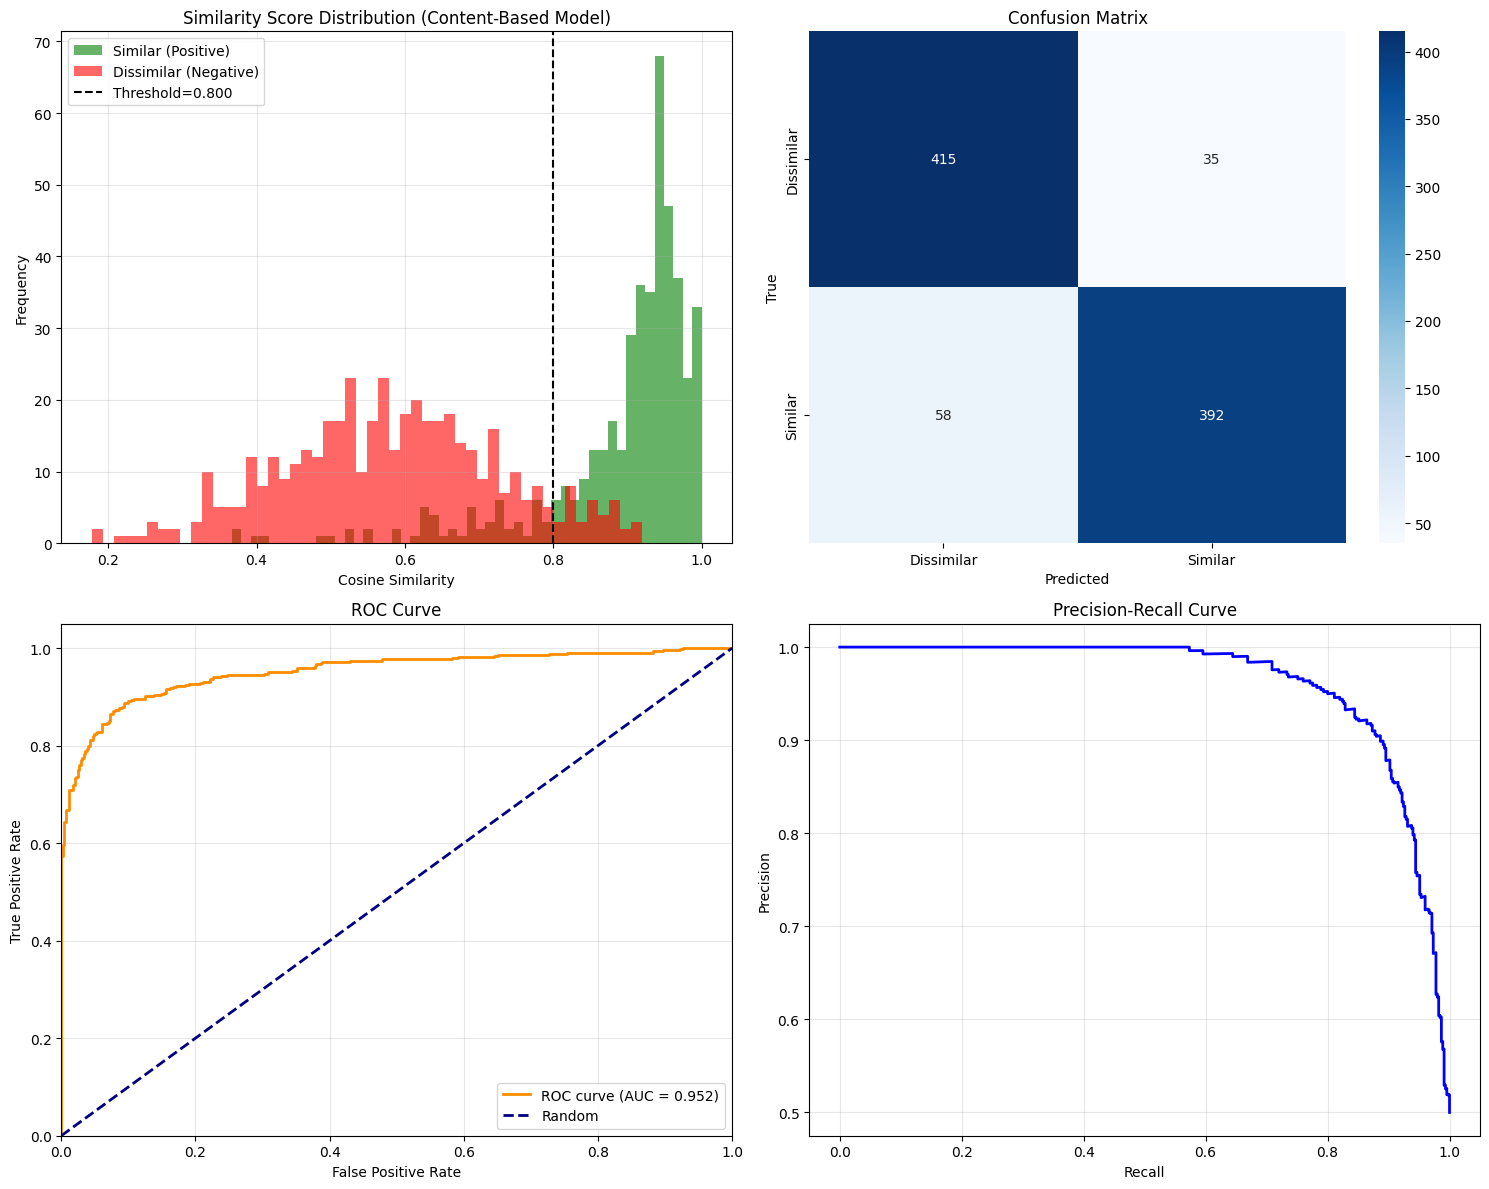


Evaluation plots saved to: ./models/job-matcher-content_20251123_110713/evaluation_metrics.png


In [15]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Similarity distribution by class
axes[0, 0].hist(similarities[true_labels==1], bins=50, alpha=0.6, label='Similar (Positive)', color='green')
axes[0, 0].hist(similarities[true_labels==0], bins=50, alpha=0.6, label='Dissimilar (Negative)', color='red')
axes[0, 0].axvline(optimal_threshold, color='black', linestyle='--', label=f'Threshold={optimal_threshold:.3f}')
axes[0, 0].set_xlabel('Cosine Similarity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Similarity Score Distribution (Content-Based Model)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_xticklabels(['Dissimilar', 'Similar'])
axes[0, 1].set_yticklabels(['Dissimilar', 'Similar'])

# 3. ROC curve
fpr, tpr, _ = roc_curve(true_labels, similarities)
roc_auc = auc(fpr, tpr)
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve')
axes[1, 0].legend(loc='lower right')
axes[1, 0].grid(alpha=0.3)

# 4. Precision-Recall curve
precision, recall, _ = precision_recall_curve(true_labels, similarities)
axes[1, 1].plot(recall, precision, color='blue', lw=2)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curve')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_path}/evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nEvaluation plots saved to: {output_path}/evaluation_metrics.png")

## 11. Compare with Base Model

In [16]:
# Load original base model
base_model = SentenceTransformer('all-MiniLM-L6-v2')

# Evaluate base model on test set
print("Evaluating base (non-fine-tuned) model...")
base_job1_embeddings = base_model.encode([ex.texts[0] for ex in test_examples], show_progress_bar=True)
base_job2_embeddings = base_model.encode([ex.texts[1] for ex in test_examples], show_progress_bar=True)

base_similarities = np.array([
    cosine_similarity([base_job1_embeddings[i]], [base_job2_embeddings[i]])[0][0]
    for i in range(len(test_examples))
])

# Find optimal threshold for base model
base_accuracies = []
for thresh in thresholds:
    pred_labels = (base_similarities >= thresh).astype(int)
    acc = accuracy_score(true_labels, pred_labels)
    base_accuracies.append(acc)

base_optimal_threshold = thresholds[np.argmax(base_accuracies)]
base_optimal_accuracy = max(base_accuracies)

print(f"\nBase Model:")
print(f"  Optimal threshold: {base_optimal_threshold:.3f}")
print(f"  Optimal accuracy: {base_optimal_accuracy:.4f}")
print(f"  Mean similarity (positive): {base_similarities[true_labels==1].mean():.4f}")
print(f"  Mean similarity (negative): {base_similarities[true_labels==0].mean():.4f}")
base_separation = base_similarities[true_labels==1].mean() - base_similarities[true_labels==0].mean()
print(f"  Separation: {base_separation:.4f}")

print(f"\nContent-Based Fine-tuned Model:")
print(f"  Optimal threshold: {optimal_threshold:.3f}")
print(f"  Optimal accuracy: {optimal_accuracy:.4f}")
print(f"  Mean similarity (positive): {similarities[true_labels==1].mean():.4f}")
print(f"  Mean similarity (negative): {similarities[true_labels==0].mean():.4f}")
finetuned_separation = similarities[true_labels==1].mean() - similarities[true_labels==0].mean()
print(f"  Separation: {finetuned_separation:.4f}")

improvement = (optimal_accuracy - base_optimal_accuracy) * 100
print(f"\nImprovement: {improvement:.2f} percentage points")
print(f"Separation improvement: {(finetuned_separation - base_separation):.4f}")

Evaluating base (non-fine-tuned) model...


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]


Base Model:
  Optimal threshold: 0.470
  Optimal accuracy: 0.6533
  Mean similarity (positive): 0.5378
  Mean similarity (negative): 0.4150
  Separation: 0.1228

Content-Based Fine-tuned Model:
  Optimal threshold: 0.800
  Optimal accuracy: 0.8967
  Mean similarity (positive): 0.8951
  Mean similarity (negative): 0.5823
  Separation: 0.3129

Improvement: 24.33 percentage points
Separation improvement: 0.1901


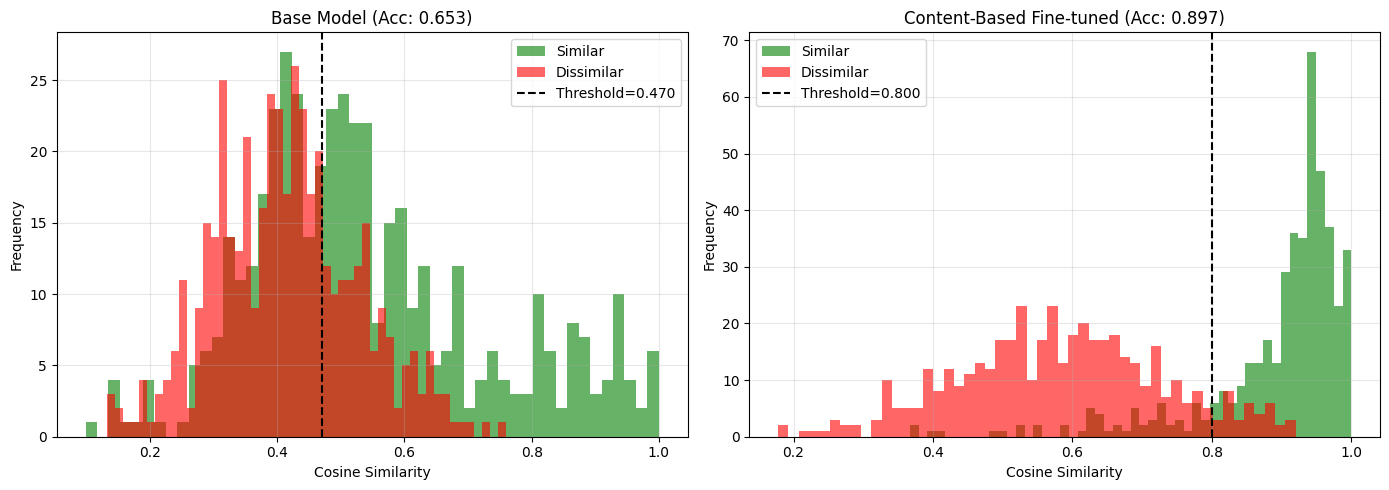


Comparison plot saved to: ./models/job-matcher-content_20251123_110713/model_comparison.png


In [17]:
# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Base model
axes[0].hist(base_similarities[true_labels==1], bins=50, alpha=0.6, label='Similar', color='green')
axes[0].hist(base_similarities[true_labels==0], bins=50, alpha=0.6, label='Dissimilar', color='red')
axes[0].axvline(base_optimal_threshold, color='black', linestyle='--', label=f'Threshold={base_optimal_threshold:.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Base Model (Acc: {base_optimal_accuracy:.3f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Fine-tuned model
axes[1].hist(similarities[true_labels==1], bins=50, alpha=0.6, label='Similar', color='green')
axes[1].hist(similarities[true_labels==0], bins=50, alpha=0.6, label='Dissimilar', color='red')
axes[1].axvline(optimal_threshold, color='black', linestyle='--', label=f'Threshold={optimal_threshold:.3f}')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Content-Based Fine-tuned (Acc: {optimal_accuracy:.3f})')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_path}/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved to: {output_path}/model_comparison.png")

## 12. Save Model Metadata

In [18]:
# Save model metadata and performance metrics
metadata = {
    'model_name': model_name,
    'timestamp': timestamp,
    'training_approach': 'content-based',
    'training_params': {
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'warmup_steps': WARMUP_STEPS,
        'evaluation_steps': EVALUATION_STEPS,
        'loss_function': 'ContrastiveLoss'
    },
    'dataset_stats': {
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df),
        'train_positive_ratio': (train_df['label']==1).sum() / len(train_df),
        'positive_pairs_different_titles': (pos_df['same_title']==0).sum() / len(pos_df)
    },
    'performance': {
        'test_accuracy': float(optimal_accuracy),
        'optimal_threshold': float(optimal_threshold),
        'roc_auc': float(roc_auc),
        'base_model_accuracy': float(base_optimal_accuracy),
        'improvement': float(optimal_accuracy - base_optimal_accuracy),
        'separation': float(finetuned_separation),
        'separation_improvement': float(finetuned_separation - base_separation),
        'positive_mean_similarity': float(similarities[true_labels==1].mean()),
        'negative_mean_similarity': float(similarities[true_labels==0].mean())
    },
    'confusion_matrix': cm.tolist()
}

with open(f'{output_path}/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Model metadata saved to: {output_path}/model_metadata.json")
print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)
print(f"\nContent-based fine-tuned model location: {output_path}")
print(f"Accuracy: {optimal_accuracy:.4f}")
print(f"Improvement over base model: {improvement:.2f} percentage points")
print(f"Separation improvement: {(finetuned_separation - base_separation):.4f}")
print(f"\n✓ This model focuses on job CONTENT (skills, duties, requirements) over titles!")

Model metadata saved to: ./models/job-matcher-content_20251123_110713/model_metadata.json

TRAINING COMPLETE!

Content-based fine-tuned model location: ./models/job-matcher-content_20251123_110713
Accuracy: 0.8967
Improvement over base model: 24.33 percentage points
Separation improvement: 0.1901

✓ This model focuses on job CONTENT (skills, duties, requirements) over titles!


## 13. Resume Matching Implementation 

Using the content-based fine-tuned SBERT model, impliment the resume matching. The process:

1. **Loaded and prepared data**: Job descriptions and resumes with semantic sentence construction
2. **Generated embeddings**: Used the fine-tuned model to embed both JDs and resumes
3. **Computed similarities**: Calculated cosine similarity scores between resume-JD pairs
4. **Extracted top matches**: For each resume, identified the top 3 most similar job descriptions
5. **Visualized results**: Created distribution plots of similarity scores
6. **Saved outputs**: Exported results to CSV for further analysis

### Key Features

- **Content-focused matching**: The model prioritizes skills, duties, and requirements over job titles
- **Cross-domain capability**: Can match resumes to jobs with different titles but similar content
- **Fine-tuned embeddings**: Leverages domain-specific training for better job-resume alignment
- **Consistent output format**: Same structure as baseline and cross-encoder models for easy comparison

In [19]:
import os

os.environ["USE_TF"] = "0"
os.environ["USE_TORCH"] = "1"

# Load the fine-tuned model
finetuned_model_path = "./models/job-matcher-content_20251121_190717"
# Load the model
from sentence_transformers import SentenceTransformer
resume_matching_model = SentenceTransformer(finetuned_model_path)


In [20]:
# 1 Load job descriptions dataset 
import pandas as pd
jd_df = pd.read_excel("../1_data_cleaning/filtered_jd_sections2.xlsx")
print(f"Loaded {len(jd_df)} job descriptions")
jd_df.head()

Loaded 1231 job descriptions


,job_description,location_cleaned,job_title,jd_duties,jd_requirements,jd_education
0,Job SummaryDo you have a strong aptitude for w...,"Natick, MA",Content Developer for MATLAB Code Generation,Software components make up an ever larger par...,Job SummaryDo you have a strong aptitude for w...,Minimum Qualifications A bachelor's degree and...
1,Overview External: Chevron is one of the world...,"Houston, TX",Land Assistant,Overview External: Chevron is one of the world...,"Prepare, and secure appropriate approvals for ...",Preferred Qualifications: Bachelor's degree
2,Overview: The Hartman Non-Profit is seeking to...,"Houston, TX",Development Associate,Overview: The Hartman Non-Profit is seeking to...,Required Abilities and Experience: · A strong ...,· A minimum of a Bachelor’s degree in a busine...
3,City: Houston State:Texas Postal/Zip Code: 770...,"Houston, TX",Asphalt Quality Control Manager -Houston,Our operations span the nation from Montana to...,Other Requirements Display a professional and ...,Qualifications Bachelor’s degree (B
4,Hiring! Immediate openings for Customer Suppor...,"San Antonio, TX",Customer Support Specialist!,Immediate openings for Customer Support Specia...,Hiring\nWe want your excellent customer servic...,High School Diploma/GED


In [21]:
# 2 Create semantic sentences for job descriptions
def jd_build_semantic_sentence(row):
    desc = str(row.get("job_description", ""))
    duties = str(row.get("jd_duties", ""))
    req = str(row.get("jd_requirements", ""))
    edu = str(row.get("jd_education", ""))
    title = str(row.get("job_title", ""))

    return (
        f"Job Posting:\n"
        f"- Job Title: {title}\n"
        f"- Description: {desc}\n"
        f"- Responsibilities: {duties}\n"
        f"- Requirements: {req}\n"
        f"- Preferred Education: {edu}"
    )

jd_df["semantic_sentence"] = jd_df.apply(jd_build_semantic_sentence, axis=1)
jd_df["jd_index"] = jd_df.index
print("Created semantic sentences for job descriptions")
jd_df.head()

Created semantic sentences for job descriptions


,job_description,location_cleaned,job_title,jd_duties,jd_requirements,jd_education,semantic_sentence,jd_index
0,Job SummaryDo you have a strong aptitude for w...,"Natick, MA",Content Developer for MATLAB Code Generation,Software components make up an ever larger par...,Job SummaryDo you have a strong aptitude for w...,Minimum Qualifications A bachelor's degree and...,Job Posting:\n- Job Title: Content Developer f...,0
1,Overview External: Chevron is one of the world...,"Houston, TX",Land Assistant,Overview External: Chevron is one of the world...,"Prepare, and secure appropriate approvals for ...",Preferred Qualifications: Bachelor's degree,Job Posting:\n- Job Title: Land Assistant\n- D...,1
2,Overview: The Hartman Non-Profit is seeking to...,"Houston, TX",Development Associate,Overview: The Hartman Non-Profit is seeking to...,Required Abilities and Experience: · A strong ...,· A minimum of a Bachelor’s degree in a busine...,Job Posting:\n- Job Title: Development Associa...,2
3,City: Houston State:Texas Postal/Zip Code: 770...,"Houston, TX",Asphalt Quality Control Manager -Houston,Our operations span the nation from Montana to...,Other Requirements Display a professional and ...,Qualifications Bachelor’s degree (B,Job Posting:\n- Job Title: Asphalt Quality Con...,3
4,Hiring! Immediate openings for Customer Suppor...,"San Antonio, TX",Customer Support Specialist!,Immediate openings for Customer Support Specia...,Hiring\nWe want your excellent customer servic...,High School Diploma/GED,Job Posting:\n- Job Title: Customer Support Sp...,4


In [22]:
# 3 Load resumes dataset
resume_df = pd.read_csv("../1_data_cleaning/resume_cleaned_100.csv")
print(f"Loaded {len(resume_df)} resumes")
resume_df.head()

Loaded 100 resumes


,career_objective,skills,degree_names,major_field_of_studies,positions,responsibilities
0,Experienced product development Engineer and m...,"['Microsoft Office', 'Microsoft Project', 'Pro...",['Bachelor of Science'],['Mechanical Engineering'],"['Engineering Manager', 'Project Engineer II',...",Management Trainee\nMechanical Systems\nMainte...
1,"I am a software engineer, and I want to work o...","['C++', 'Python', 'Firebase', 'Flutter', 'Tens...",['B.Tech'],['Computers'],['SDE'],Recruitment Coordination\nAppointment Manageme...
2,I desire to work for a company that provides c...,"['Word', 'SAP Time Approval', 'Excel', 'Travel...",['Associate of Arts'],['Administrative Assistance'],"['ENGINEERING COORDINATOR', 'FACILITIES TEMP',...",Machine Learning Design\nData Analysis\nModel ...
3,As a Data Analyst I always look into more inno...,"['Machine Learning', 'Artificial Intelligence'...","['B.Tech', 'M.Tech']","[None, None]",['Data Analyst'],Mikrotik Router Configuration\nOLT Device Setu...
4,Financial and Accounting professional with exp...,['Power User of Microsoft Excel Epicor NetSuit...,['Bachelor of Business Administration'],['Accounting'],"['Senior Accountant', 'Senior Accountant/Finan...",Design Creation\nCAD Drawings\nDesign Optimiza...


In [23]:
# 5 Embed job description semantic sentences using the fine-tuned model
print("Embedding job descriptions...")
jd_df["semantic_emb"] = jd_df["semantic_sentence"].apply(lambda x: resume_matching_model.encode(x))
print(f"Embedded {len(jd_df)} job descriptions")
jd_df.head()

Embedding job descriptions...
Embedded 1231 job descriptions


,job_description,location_cleaned,job_title,jd_duties,jd_requirements,jd_education,semantic_sentence,jd_index,semantic_emb
0,Job SummaryDo you have a strong aptitude for w...,"Natick, MA",Content Developer for MATLAB Code Generation,Software components make up an ever larger par...,Job SummaryDo you have a strong aptitude for w...,Minimum Qualifications A bachelor's degree and...,Job Posting:\n- Job Title: Content Developer f...,0,"[-0.05470385, -0.025351055, -0.01402331, -0.00..."
1,Overview External: Chevron is one of the world...,"Houston, TX",Land Assistant,Overview External: Chevron is one of the world...,"Prepare, and secure appropriate approvals for ...",Preferred Qualifications: Bachelor's degree,Job Posting:\n- Job Title: Land Assistant\n- D...,1,"[-0.009074108, -0.030419752, 0.05705658, -0.07..."
2,Overview: The Hartman Non-Profit is seeking to...,"Houston, TX",Development Associate,Overview: The Hartman Non-Profit is seeking to...,Required Abilities and Experience: · A strong ...,· A minimum of a Bachelor’s degree in a busine...,Job Posting:\n- Job Title: Development Associa...,2,"[-0.0035906709, -0.043059837, -0.009483769, -0..."
3,City: Houston State:Texas Postal/Zip Code: 770...,"Houston, TX",Asphalt Quality Control Manager -Houston,Our operations span the nation from Montana to...,Other Requirements Display a professional and ...,Qualifications Bachelor’s degree (B,Job Posting:\n- Job Title: Asphalt Quality Con...,3,"[-0.069340564, -0.046399187, 0.12254029, -0.07..."
4,Hiring! Immediate openings for Customer Suppor...,"San Antonio, TX",Customer Support Specialist!,Immediate openings for Customer Support Specia...,Hiring\nWe want your excellent customer servic...,High School Diploma/GED,Job Posting:\n- Job Title: Customer Support Sp...,4,"[-0.08399336, -0.042924307, 0.08856369, -0.018..."


In [24]:
# 4 Create semantic sentences for resumes
def resume_build_semantic_sentence(row):
    def clean(value):
        if value is None:
            return ""
        if isinstance(value, list):
            return ", ".join([str(v) for v in value])
        return str(value).strip()

    career = clean(row.get("career_objective", ""))
    skills = clean(row.get("skills", ""))
    degrees = clean(row.get("degree_names", ""))
    majors = clean(row.get("major_field_of_studies", ""))
    work_exp = clean(row.get("responsibilities", ""))

    return (
        "Candidate Profile:\n"
        f"- Career Objective: {career}\n"
        f"- Work Experience: {work_exp}\n"
        f"- Skills: {skills}\n"
        f"- Degrees: {degrees}\n"
        f"- Major Field(s) of Study: {majors}"
    )

# Create semantic sentences for resumes
resume_df["semantic_sentence"] = resume_df.apply(resume_build_semantic_sentence, axis=1)
resume_df["resume_index"] = resume_df.index
print("Created semantic sentences for resumes")
resume_df.head()

Created semantic sentences for resumes


,career_objective,skills,degree_names,major_field_of_studies,positions,responsibilities,semantic_sentence,resume_index
0,Experienced product development Engineer and m...,"['Microsoft Office', 'Microsoft Project', 'Pro...",['Bachelor of Science'],['Mechanical Engineering'],"['Engineering Manager', 'Project Engineer II',...",Management Trainee\nMechanical Systems\nMainte...,Candidate Profile:\n- Career Objective: Experi...,0
1,"I am a software engineer, and I want to work o...","['C++', 'Python', 'Firebase', 'Flutter', 'Tens...",['B.Tech'],['Computers'],['SDE'],Recruitment Coordination\nAppointment Manageme...,Candidate Profile:\n- Career Objective: I am a...,1
2,I desire to work for a company that provides c...,"['Word', 'SAP Time Approval', 'Excel', 'Travel...",['Associate of Arts'],['Administrative Assistance'],"['ENGINEERING COORDINATOR', 'FACILITIES TEMP',...",Machine Learning Design\nData Analysis\nModel ...,Candidate Profile:\n- Career Objective: I desi...,2
3,As a Data Analyst I always look into more inno...,"['Machine Learning', 'Artificial Intelligence'...","['B.Tech', 'M.Tech']","[None, None]",['Data Analyst'],Mikrotik Router Configuration\nOLT Device Setu...,Candidate Profile:\n- Career Objective: As a D...,3
4,Financial and Accounting professional with exp...,['Power User of Microsoft Excel Epicor NetSuit...,['Bachelor of Business Administration'],['Accounting'],"['Senior Accountant', 'Senior Accountant/Finan...",Design Creation\nCAD Drawings\nDesign Optimiza...,Candidate Profile:\n- Career Objective: Financ...,4


In [25]:
# 6 Embed resume semantic sentences using the fine-tuned model
print("Embedding resumes...")
resume_df["semantic_emb"] = resume_df["semantic_sentence"].apply(lambda x: resume_matching_model.encode(x))
print(f"Embedded {len(resume_df)} resumes")
resume_df.head()

Embedding resumes...
Embedded 100 resumes


,career_objective,skills,degree_names,major_field_of_studies,positions,responsibilities,semantic_sentence,resume_index,semantic_emb
0,Experienced product development Engineer and m...,"['Microsoft Office', 'Microsoft Project', 'Pro...",['Bachelor of Science'],['Mechanical Engineering'],"['Engineering Manager', 'Project Engineer II',...",Management Trainee\nMechanical Systems\nMainte...,Candidate Profile:\n- Career Objective: Experi...,0,"[-0.05778806, -0.08858334, 0.05353307, -0.0185..."
1,"I am a software engineer, and I want to work o...","['C++', 'Python', 'Firebase', 'Flutter', 'Tens...",['B.Tech'],['Computers'],['SDE'],Recruitment Coordination\nAppointment Manageme...,Candidate Profile:\n- Career Objective: I am a...,1,"[-0.043648884, -0.0592803, 0.020093264, -0.015..."
2,I desire to work for a company that provides c...,"['Word', 'SAP Time Approval', 'Excel', 'Travel...",['Associate of Arts'],['Administrative Assistance'],"['ENGINEERING COORDINATOR', 'FACILITIES TEMP',...",Machine Learning Design\nData Analysis\nModel ...,Candidate Profile:\n- Career Objective: I desi...,2,"[-0.027087208, -0.06490992, 0.012557171, 0.021..."
3,As a Data Analyst I always look into more inno...,"['Machine Learning', 'Artificial Intelligence'...","['B.Tech', 'M.Tech']","[None, None]",['Data Analyst'],Mikrotik Router Configuration\nOLT Device Setu...,Candidate Profile:\n- Career Objective: As a D...,3,"[-0.07480852, -0.07566458, 0.037372634, 0.0200..."
4,Financial and Accounting professional with exp...,['Power User of Microsoft Excel Epicor NetSuit...,['Bachelor of Business Administration'],['Accounting'],"['Senior Accountant', 'Senior Accountant/Finan...",Design Creation\nCAD Drawings\nDesign Optimiza...,Candidate Profile:\n- Career Objective: Financ...,4,"[-0.05218964, -0.012843246, -0.0035057121, -0...."


In [26]:
# 7 Convert embeddings to numpy arrays for compatibility
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

jd_df["semantic_emb"] = jd_df["semantic_emb"].apply(lambda x: np.array(x))
resume_df["semantic_emb"] = resume_df["semantic_emb"].apply(lambda x: np.array(x))
print("Converted embeddings to numpy arrays")

Converted embeddings to numpy arrays


In [27]:
# 8 Function to match a single resume to top-k job descriptions
def match_resume_to_jobs(resume_row, jd_df, top_k=3):
    """
    Match a resume to the top-k most similar job descriptions using cosine similarity.
    
    Args:
        resume_row: A single row from the resume DataFrame
        jd_df: DataFrame containing job descriptions with embeddings
        top_k: Number of top matches to return
        
    Returns:
        List of dictionaries containing match information
    """
    resume_emb = np.array(resume_row["semantic_emb"])
    
    # Stack all JD embeddings into a matrix
    jd_embs = np.vstack(jd_df["semantic_emb"].values)
    
    # Calculate cosine similarities
    sims = cosine_similarity(resume_emb.reshape(1, -1), jd_embs)[0]
    
    # Get indices of top-k matches
    top_idx = sims.argsort()[::-1][:top_k]
    
    # Build result list
    result_rows = []
    for rank, jd_i in enumerate(top_idx, 1):
        result_rows.append({
            "jd_index": int(jd_df.iloc[jd_i]["jd_index"]),
            "job_title": jd_df.iloc[jd_i]["job_title"],
            "location_cleaned": jd_df.iloc[jd_i]["location_cleaned"],
            "similarity": float(sims[jd_i])
        })
    
    return result_rows

print("Resume matching function defined")

Resume matching function defined


In [28]:
# 9 Match all resumes to top-3 job descriptions
output_rows = []

print("Matching resumes to job descriptions...")
for i in range(len(resume_df)):
    row = resume_df.iloc[i]
    topn = match_resume_to_jobs(row, jd_df, top_k=3)
    
    # Ensure we always have 3 matches (pad with NaN if needed)
    while len(topn) < 3:
        topn.append({
            "jd_index": np.nan,
            "job_title": "",
            "location_cleaned": "",
            "similarity": np.nan
        })
    
    output_rows.append({
        "resume_index": row["resume_index"],
        "resume_career_objective": row.get("career_objective", ""),
        "resume_skills": row.get("skills", ""),
        "resume_degree_names": row.get("degree_names", ""),
        "resume_major_field_of_studies": row.get("major_field_of_studies", ""),
        "resume_responsibilities": row.get("responsibilities", ""),
        
        "top1_jd_index": topn[0]["jd_index"],
        "top1_similarity": topn[0]["similarity"],
        "top1_job_title": topn[0]["job_title"],
        "top1_location_cleaned": topn[0]["location_cleaned"],
        
        "top2_jd_index": topn[1]["jd_index"],
        "top2_similarity": topn[1]["similarity"],
        "top2_job_title": topn[1]["job_title"],
        "top2_location_cleaned": topn[1]["location_cleaned"],
        
        "top3_jd_index": topn[2]["jd_index"],
        "top3_similarity": topn[2]["similarity"],
        "top3_job_title": topn[2]["job_title"],
        "top3_location_cleaned": topn[2]["location_cleaned"],
    })

content_df = pd.DataFrame(output_rows)
print(f"Matched {len(content_df)} resumes")
content_df.head()

Matching resumes to job descriptions...
Matched 100 resumes


,resume_index,resume_career_objective,resume_skills,resume_degree_names,resume_major_field_of_studies,resume_responsibilities,top1_jd_index,top1_similarity,top1_job_title,top1_location_cleaned,top2_jd_index,top2_similarity,top2_job_title,top2_location_cleaned,top3_jd_index,top3_similarity,top3_job_title,top3_location_cleaned
0,0,Experienced product development Engineer and m...,"['Microsoft Office', 'Microsoft Project', 'Pro...",['Bachelor of Science'],['Mechanical Engineering'],Management Trainee\nMechanical Systems\nMainte...,637,0.803072,Pega Developer,"Boston, MA",1176,0.792622,Shipping/Packer,"San Antonio, TX",1178,0.792242,Shipping/Packer,"San Antonio, TX"
1,1,"I am a software engineer, and I want to work o...","['C++', 'Python', 'Firebase', 'Flutter', 'Tens...",['B.Tech'],['Computers'],Recruitment Coordination\nAppointment Manageme...,158,0.782403,Developer Analyst,"Cincinnati, OH",228,0.773639,Software Engineer and Analyst,"Santa Barbara, CA",960,0.773384,Software Engineer,"Tulsa, OK"
2,2,I desire to work for a company that provides c...,"['Word', 'SAP Time Approval', 'Excel', 'Travel...",['Associate of Arts'],['Administrative Assistance'],Machine Learning Design\nData Analysis\nModel ...,736,0.833603,ASEAN Practice Leader,"Boise, ID",89,0.832281,Sr. SAP BW Developer,"San Antonio, TX",687,0.815794,Service Delivery Manager – Application Product...,"Pittsburgh, PA"
3,3,As a Data Analyst I always look into more inno...,"['Machine Learning', 'Artificial Intelligence'...","['B.Tech', 'M.Tech']","[None, None]",Mikrotik Router Configuration\nOLT Device Setu...,1013,0.783569,Business Marketing Principal Technical Archite...,"Dallas, TX",1033,0.776229,Principal Member of Technical Staff Data Scien...,"Dallas, TX",228,0.774623,Software Engineer and Analyst,"Santa Barbara, CA"
4,4,Financial and Accounting professional with exp...,['Power User of Microsoft Excel Epicor NetSuit...,['Bachelor of Business Administration'],['Accounting'],Design Creation\nCAD Drawings\nDesign Optimiza...,827,0.905791,Bookkeeper - Construction,"Somerville, MA",1209,0.905082,Lead Accountant,"Cincinnati, OH",919,0.901683,University - Finance & Accounting Majors (Rece...,"Omaha, NE"


In [29]:
# 10 Display sample matches
print("Sample resume matches:")
for i in range(min(3, len(content_df))):
    row = content_df.iloc[i]
    print(f"\n{'='*80}")
    print(f"Resume #{i}")

    # retrieve skills (content_df uses 'resume_skills')
    skills = row.get('resume_skills', '')
    if isinstance(skills, (list, tuple)):
        skills_str = ", ".join([str(s) for s in skills])
    else:
        skills_str = str(skills)
    print(f"Skills: {skills_str[:200]}...")

    print(f"\nTop 3 Matches:")
    for rank in range(1, 4):
        title = row.get(f'top{rank}_job_title', '')
        loc = row.get(f'top{rank}_location_cleaned', '')
        sim = row.get(f'top{rank}_similarity', np.nan)
        try:
            sim_val = float(sim)
            sim_str = f"{sim_val:.4f}"
        except Exception:
            sim_str = "nan"
        print(f"  {rank}. {title} ({loc}) - Similarity: {sim_str}")
    print(f"{'='*80}")

Sample resume matches:

Resume #0
Skills: ['Microsoft Office', 'Microsoft Project', 'Product development', 'Quality', 'Research', 'Six Sigma Green Belt', 'Solid Works', 'Visio', 'Prioritization', 'Personnel management', 'Critical thinking ski...

Top 3 Matches:
  1. Pega Developer (Boston, MA) - Similarity: 0.8031
  2. Shipping/Packer (San Antonio, TX) - Similarity: 0.7926
  3. Shipping/Packer (San Antonio, TX) - Similarity: 0.7922

Resume #1
Skills: ['C++', 'Python', 'Firebase', 'Flutter', 'Tensorflow', 'Pandas', 'Numpy', 'Kotlin', 'Java', 'MongoDB', 'NoSQL']...

Top 3 Matches:
  1. Developer Analyst (Cincinnati, OH) - Similarity: 0.7824
  2. Software Engineer and Analyst (Santa Barbara, CA) - Similarity: 0.7736
  3. Software Engineer (Tulsa, OK) - Similarity: 0.7734

Resume #2
Skills: ['Word', 'SAP Time Approval', 'Excel', 'Travel Arranger', 'Access Database', 'Purchase Reqs in SAP', 'OutLook', 'IOs in SAP', 'Pcard purchases', 'Royalty Agreement Tracking']...

Top 3 Matches:
  1. ASE

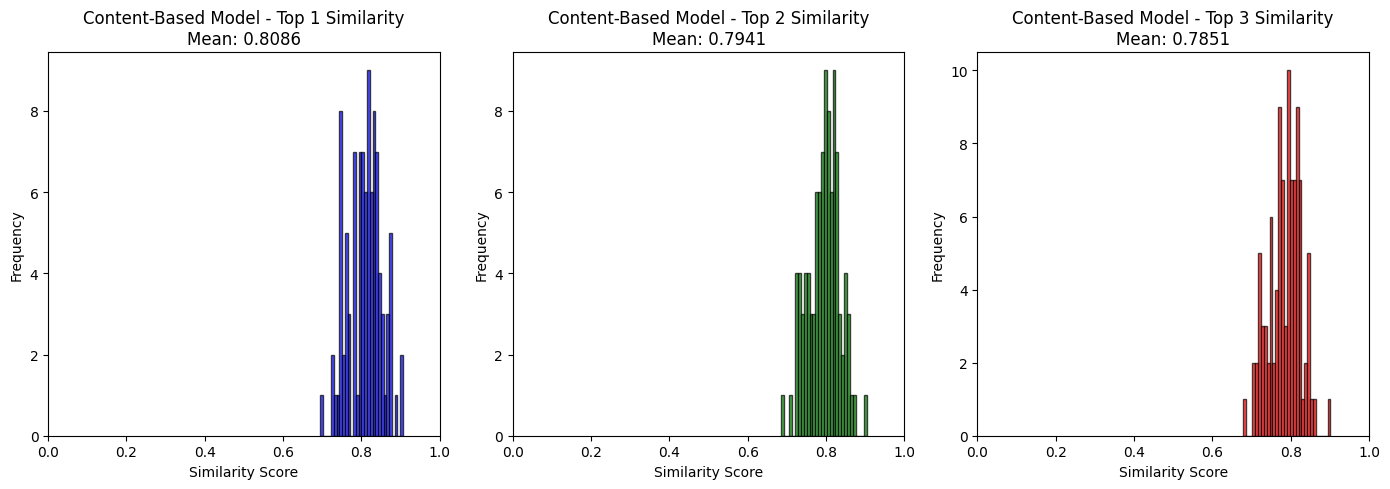


Similarity distributions saved to: ./models/job-matcher-content_20251123_110713/resume_matching_similarity_scores.png


In [30]:
# 11 Visualize similarity score distributions
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Helper function for smart histogram plotting
def smart_hist(ax, data, color, title):
    unique_vals = np.unique(data)
    
    if len(unique_vals) == 1:
        # All values are identical - plot a visible bar
        val = unique_vals[0]
        count = len(data)
        ax.bar([val], [count], width=0.01, color=color, edgecolor='black')
        ax.set_xlim(val - 0.05, val + 0.05)
        ax.set_title(title)
        ax.set_xlabel('Similarity Score')
        ax.set_ylabel('Frequency')
    else:
        # Normal histogram
        ax.hist(data, bins=30, alpha=0.7, color=color, edgecolor='black')
        ax.set_xlim(0, 1)
        ax.set_title(title)
        ax.set_xlabel('Similarity Score')
        ax.set_ylabel('Frequency')

# Top 1 matches
content_top1_sims = content_df['top1_similarity']
smart_hist(
    axes[0],
    content_top1_sims,
    color='blue',
    title=f'Content-Based Model - Top 1 Similarity\nMean: {content_top1_sims.mean():.4f}'
)

# Top 2 matches
content_top2_sims = content_df['top2_similarity']
smart_hist(
    axes[1],
    content_top2_sims,
    color='green',
    title=f'Content-Based Model - Top 2 Similarity\nMean: {content_top2_sims.mean():.4f}'
)

# Top 3 matches
content_top3_sims = content_df['top3_similarity']
smart_hist(
    axes[2],
    content_top3_sims,
    color='red',
    title=f'Content-Based Model - Top 3 Similarity\nMean: {content_top3_sims.mean():.4f}'
)

plt.tight_layout()
plt.savefig(f'{output_path}/resume_matching_similarity_scores.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSimilarity distributions saved to: {output_path}/resume_matching_similarity_scores.png")

In [31]:
# 12 Save results to CSV
output_csv_path = "../4_model_outputs/content_based_outputs.csv"
content_df.to_csv(output_csv_path, index=False)
print(f"Results saved to: {output_csv_path}")
print(f"\nSummary Statistics:")
print(f"  Total resumes matched: {len(content_df)}")
print(f"  Average top-1 similarity: {content_df['top1_similarity'].mean():.4f}")
print(f"  Average top-2 similarity: {content_df['top2_similarity'].mean():.4f}")
print(f"  Average top-3 similarity: {content_df['top3_similarity'].mean():.4f}")
print(f"  Min top-1 similarity: {content_df['top1_similarity'].min():.4f}")
print(f"  Max top-1 similarity: {content_df['top1_similarity'].max():.4f}")

Results saved to: ../4_model_outputs/content_based_outputs.csv

Summary Statistics:
  Total resumes matched: 100
  Average top-1 similarity: 0.8086
  Average top-2 similarity: 0.7941
  Average top-3 similarity: 0.7851
  Min top-1 similarity: 0.6942
  Max top-1 similarity: 0.9058
